# Setup for downloading Yelp Dataset in Kaggle

In [1]:
 !pip install -q kaggle
 !pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 4.1 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=d22f77f398dd88e226b0528434d5be5c578610c0e24189560acbd932294eb41b
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [2]:
# Choose the kaggle.json file that you downloaded
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sejinchun","key":"14e04457c24456020a0ba073f807b42a"}'}

In [3]:
# Make directory named kaggle and copy kaggle.json file there.
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json #Change the permissions of the file.

In [5]:
!kaggle datasets download -d yelp-dataset/yelp-dataset

100% 4.92G/4.92G [00:57<00:00, 94.5MB/s]
100% 4.92G/4.92G [00:57<00:00, 91.7MB/s]


In [6]:
!mkdir data 
!unzip yelp-dataset.zip -d data #unzip

Archive:  yelp-dataset.zip
  inflating: data/Dataset_User_Agreement.pdf  
  inflating: data/yelp_academic_dataset_business.json  
  inflating: data/yelp_academic_dataset_checkin.json  
  inflating: data/yelp_academic_dataset_review.json  
  inflating: data/yelp_academic_dataset_tip.json  
  inflating: data/yelp_academic_dataset_user.json  


# libraries

In [7]:
# !pip install pyarrow

In [8]:
import gc # garbage collector
import numpy as np # linear algebra
from collections import Counter # for counting commong words
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json

import matplotlib.pyplot as plt # visualization
plt.style.use('fivethirtyeight') # use ggplot ploting style

import seaborn as sns # visualization 
from wordcloud import WordCloud, STOPWORDS # this module is for making wordcloud in python
import re # regular expression
import string # for finding punctuation in text
import nltk # preprocessing text
from textblob import TextBlob

# remove war
import warnings
warnings.filterwarnings('ignore')
# this will allow ploting inside the notebook
%matplotlib inline

# Imports & Preprocessing

In [9]:
def read_json(filename, limit=100000):
  data = []
  with open(filename) as fl:
      for i, line in enumerate(fl):
          data.append(json.loads(line))
          if i+1 >= limit:
              break
  return pd.DataFrame(data)

In [10]:
%timeit
#importing every dataset
business = read_json("/content/data/yelp_academic_dataset_business.json", limit=99999999)
review = read_json("/content/data/yelp_academic_dataset_review.json", limit=200000)
tip = read_json("/content/data/yelp_academic_dataset_tip.json")

In [11]:
review.shape

(200000, 9)

In [12]:
tip.shape

(100000, 5)

레스토랑만 추출

In [ ]:
# 가장 인기 있는 비지니스 카테고리?
business = business[business.categories.notnull()]
business_cats =' '.join(business['categories'])

cats=pd.DataFrame(business_cats.split(','),columns=['category'])
x=cats.category.value_counts()
print("There are ",len(x)," different types/categories of Businesses in Yelp!")
#prep for chart
x=x.sort_values(ascending=False)
x=x.iloc[0:20]
x

In [13]:
df_category_split = business['categories'].str.split(',', expand=True)[[0,1,2]]
# rename the new columns
df_category_split.columns = ['category_1', 'category_2', 'category_3']
business = pd.concat([business, df_category_split], axis=1)
# now drop the actual categories column
business = business.drop(['categories'], axis=1)
# print the head of the dataset
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,hours,category_1,category_2,category_3
0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86,1,"{'RestaurantsTableService': 'True', 'WiFi': 'u...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",Gastropubs,Food,Beer Gardens
1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ...",Salad,Soup,Sandwiches
2,bvN78flM8NLprQ1a1y5dRg,The Reclaimory,4720 Hawthorne Ave,Portland,OR,97214,45.511907,-122.613693,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","{'Thursday': '11:0-18:0', 'Friday': '11:0-18:0...",Antiques,Fashion,Used
3,oaepsyvc0J17qwi8cfrOWg,Great Clips,2566 Enterprise Rd,Orange City,FL,32763,28.914482,-81.295979,3.0,8,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...",None,Beauty & Spas,Hair Salons,None
4,PE9uqAjdw0E4-8mjGl3wVA,Crossfit Terminus,1046 Memorial Dr SE,Atlanta,GA,30316,33.747027,-84.353424,4.0,14,1,"{'GoodForKids': 'False', 'BusinessParking': '{...","{'Monday': '16:0-19:0', 'Tuesday': '16:0-19:0'...",Gyms,Active Life,Interval Training Gyms


In [14]:
restaurants = business.loc[(business['category_1'] == 'Restaurants') | (business['category_2'] == 'Restaurants') | (business['category_3'] == 'Restaurants')]
restaurants.shape

(14423, 16)

# 상위/하위 레스토랑 및 관련 리뷰 분석

## 레스토랑, 관련 리뷰 추출

In [15]:
# join the restaurants dataframe with review one on 'business_id' key
review['name'] = review['business_id'].map(restaurants.set_index('business_id')['name'])

In [37]:
# Top20 레스토랑 (이런 리뷰순)
top_restaurants = restaurants.name.value_counts().index[:20].tolist()

review_top = review.loc[review['name'].isin(top_restaurants)]

In [17]:
# Bottom20 레스토랑의 리뷰 추출
bottom_restaurants = restaurants[restaurants['stars'] <= 2.0 ].name.value_counts().index[:20]

review_bottom = review.loc[review['name'].isin(bottom_restaurants)]

## 레스토랑 평점 출력

In [18]:
def draw_restaurants_ratings( df_res_review ):
  df_res_review.groupby(df_res_review.name)['stars'].mean().sort_values(ascending=True).plot(kind='barh',figsize=(12, 10))
  # set y ticks font size to 18 for easy readable purposes.
  plt.yticks(fontsize=18)
  # set the title of the graph
  plt.title('Top(or Bottom) rated restaurants on Yelp',fontsize=20)
  # set y label of the graph and change fontsize to 18 for readablity purposes. 
  plt.ylabel('Restaurants names', fontsize=18)
  # set x label to 'Ratings'
  plt.xlabel('Ratings', fontsize=18)
  # now finally show the graph in a new window. 
  plt.show()

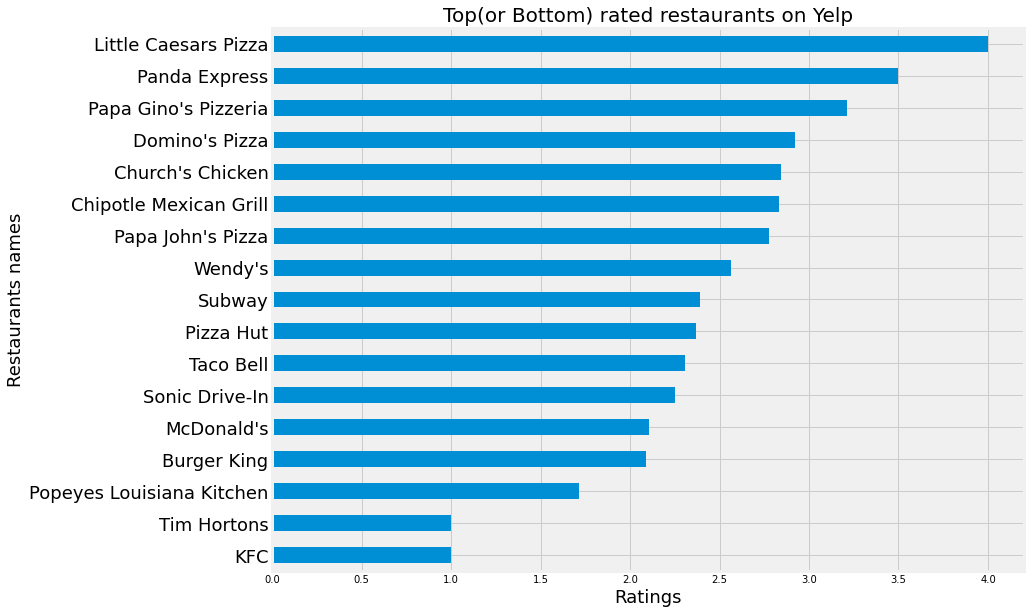

In [19]:
draw_restaurants_ratings(review_bottom)

NLP Preprocessing & Sentiment with Blob

In [20]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [21]:
# 텍스트 전처리
def preprocess(x):
    x = re.sub('[^a-z\s]', '', x.lower())                  # get rid of noise
    x = [w for w in x.split() if w not in set(stopwords)]  # remove stopwords
    return ' '.join(x) # then join the text again
# Stopwords, eg., a, the, he 등
i = nltk.corpus.stopwords.words('english')
# punctuations to remove
j = list(string.punctuation)
# finally let's combine all of these
stopwords = set(i).union(j)
review_top['text_clear'] = review_top['text'].apply(preprocess)

In [22]:
# 텍스트 전처리 전후 결과
review_top.loc[:, ['text','text_clear']].head(10)

,text,text_clear
592,Is there an option for no stars?\n\nI am a uni...,option stars university student obviously eat ...
2797,Average at best. Been twice second time defini...,average best twice second time definitely sham...
3801,"For those of you who are whining ""it's just ri...",whining rice beans make bowl ingredients youre...
6585,My favorite breakfast place! Their food is re...,favorite breakfast place food really good fres...
7535,I quite enjoy this food cart. It's really all...,quite enjoy food cart really tali sauce find d...
7897,I so love all the Mod Pizza locations which ke...,love mod pizza locations keep popping great wa...
7965,While trying to decide which food truck to get...,trying decide food truck get lunch noticed lon...
10337,Food is absolutely DELICIOUS. I'm picky as hec...,food absolutely delicious im picky heck breakf...
11205,This new location is absolutely amazing! Being...,new location absolutely amazing able add many ...
13289,"Great breakfast. Had the Greek omelette, home...",great breakfast greek omelette home fries side...


In [23]:
# 감성 분석
def sentiment(x):
    sentiment = TextBlob(x)
    return sentiment.sentiment.polarity

# 감성 분석 +1이면 긍정 -1이면 부정
review_top['senti_polarity'] = review_top['text_clear'].apply(sentiment)

In [24]:
review_top.loc[:, ['text_clear','senti_polarity']].head(10)

,text_clear,senti_polarity
592,option stars university student obviously eat ...,-0.081498
2797,average best twice second time definitely sham...,0.170000
3801,whining rice beans make bowl ingredients youre...,0.268750
6585,favorite breakfast place food really good fres...,0.364286
7535,quite enjoy food cart really tali sauce find d...,0.386667
7897,love mod pizza locations keep popping great wa...,0.368182
7965,trying decide food truck get lunch noticed lon...,0.310000
10337,food absolutely delicious im picky heck breakf...,0.218750
11205,new location absolutely amazing able add many ...,0.491942
13289,great breakfast greek omelette home fries side...,0.526667


## 레스토랑 리뷰 태그 출력
함수화 하기

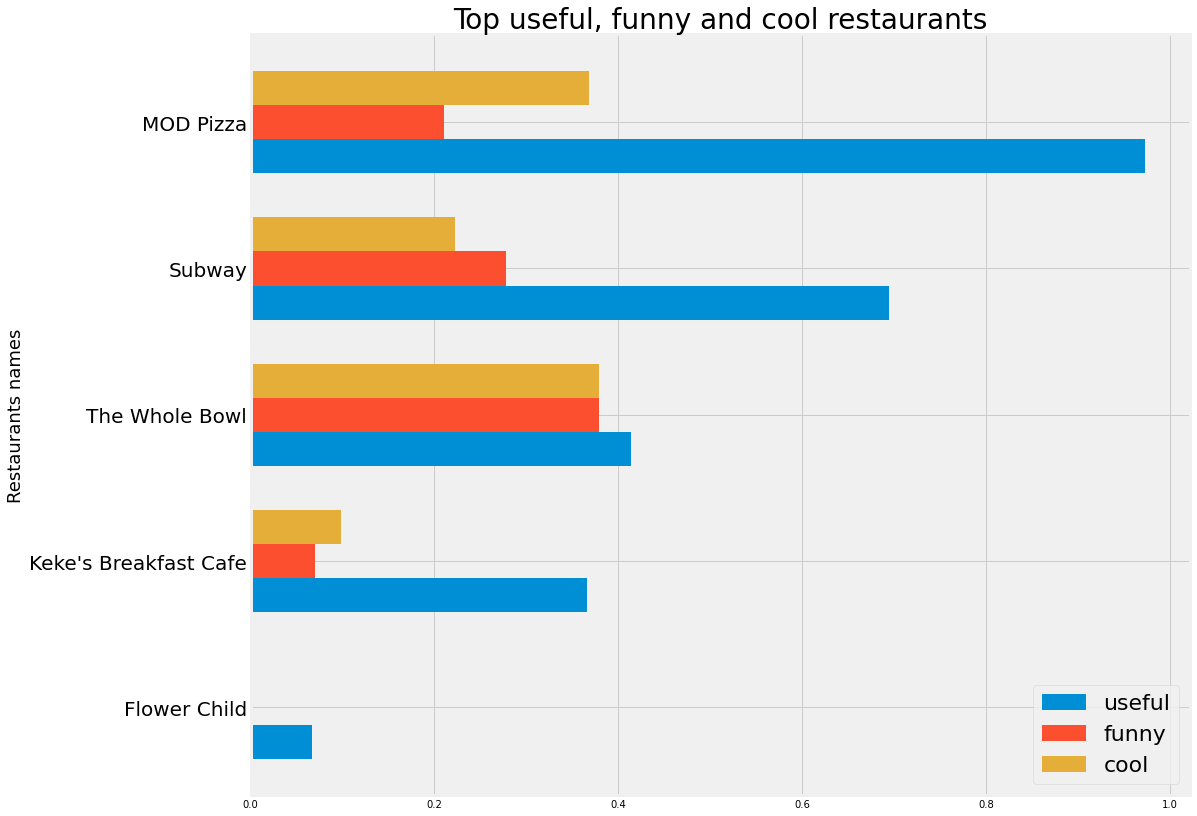

In [25]:
review_top.groupby(review_top.name)[['useful','funny', 'cool']].mean().sort_values('useful',ascending=True).plot(kind='barh', figsize=(15, 14),width=0.7)
# set y ticks font size to 18 for easy readable purposes.
plt.yticks(fontsize=18)
# set the title of the graph
plt.title('Top useful, funny and cool restaurants',fontsize=28)
# set y label of the graph and change fontsize to 18 for readablity purposes.
plt.ylabel('Restaurants names', fontsize=18)
# set the y ticks
plt.yticks(fontsize=20)
plt.legend(fontsize=22)
# finally show the plot
plt.show()

## 레스토랑 팁 출력하기

In [26]:
def draw_tips_of_review(df_tip):
  df_tip['name'] = df_tip['business_id'].map(restaurants.set_index('business_id')['name'])
  # create a new dataframe called 'df_yelp_tip_top' that only contains the reviews of 'top_restaurants'
  tip_top = df_tip.loc[df_tip['name'].isin(top_restaurants)]

  # pre process the text
  tip_top['text_clear'] = tip_top['text'].apply(preprocess)

  # difine wordcloud function from wordcloud library. set some parameteres for beatuful plotting
  wc = WordCloud(width=1600, height=800, random_state=1, max_words=200000000)
  # generate word cloud using df_yelp_tip_top['text_clear']
  wc.generate(str(tip_top['text_clear']))
  # declare our figure 
  plt.figure(figsize=(20,10), facecolor='k')
  # add title to the graph
  plt.title("Tips for top reviewed restaurant", fontsize=40,color='white')
  plt.imshow(wc, interpolation='bilinear')
  plt.axis('off')
  plt.tight_layout(pad=10)
  # after lot of congiguration finally plot the graph
  plt.show()

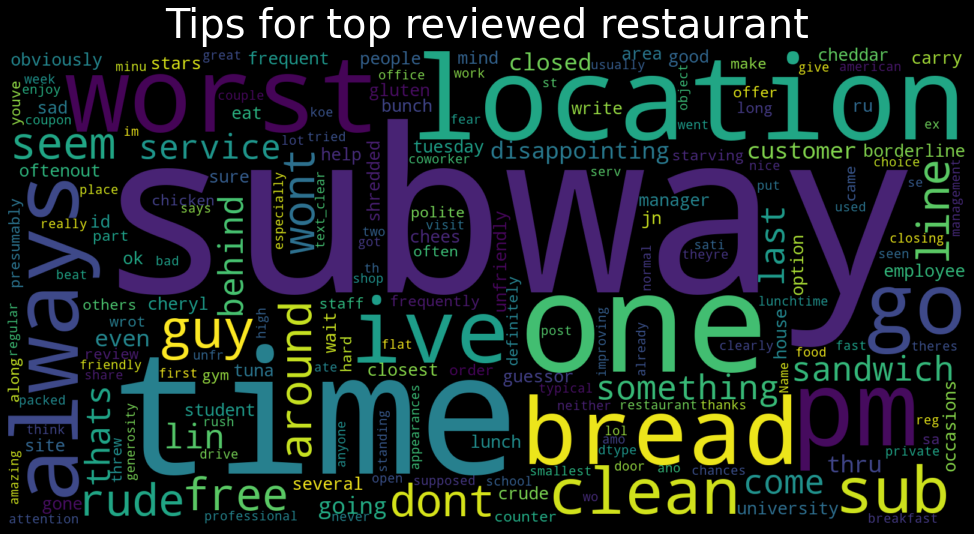

In [27]:
draw_tips_of_review(review_bottom)

In [28]:
def search_tips(df_tip, keyword):
  df_tip['name'] = df_tip['business_id'].map(restaurants.set_index('business_id')['name'])
  return df_tip.loc[df_tip['text'].str.contains(keyword) & df_tip['name'].notna() ]

search_tips(tip, 'subway').head(10)

,user_id,business_id,text,date,compliment_count,name
11603,iGe2HHrrznPLYQ82W-FwIQ,33m9KXgCfJcFy4PR4zB53w,Use a subway rewards card to collect points.,2015-09-03 21:28:39,0,Subway
14385,OuPzokcIhyd3bVp0rtDd0A,VKKULPUhvStzt_yXxl-hyw,Great fast service and really friendly people ...,2012-05-23 19:54:40,0,Subway
87511,hZgaNIxLv0zLx6O83bLQPA,AS_r7z1MKVWy8-ip3hfvRw,Betta than subway!,2011-10-25 18:48:53,0,Baldinos Giant Jersey Subs


## 레스토랑의 워드클라우드를 출력

In [29]:
def make_wordcloud( name ):
  restaurant_only = restaurants.loc[restaurants['name'] == name ]
  # filter reviews for only Earl of Sandwich
  restaurant_review = review.loc[review['business_id'].isin(restaurant_only.business_id)]

  # clear the text
  restaurant_review['text_clear'] = restaurant_review['text'].apply(preprocess)

  wc = WordCloud(width=1600, height=800, random_state=1, max_words=200000000)
  # generate word cloud
  wc.generate(str(restaurant_review['text_clear']))
  plt.figure(figsize=(20,10), facecolor='k')
  # add title to the graph
  plt.title(f"Customers reviews about '{name}' restaurant", fontsize=40,color='white')
  plt.imshow(wc, interpolation='bilinear')
  plt.axis('off')
  plt.tight_layout(pad=10)
  # after lot of configuration finally plot the graph
  plt.show()

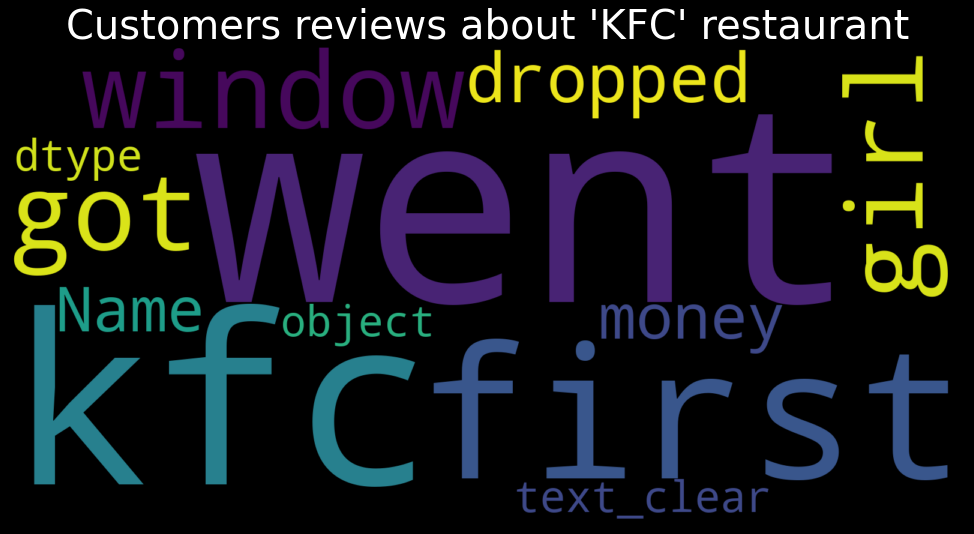

In [30]:
make_wordcloud('KFC')

## 레스토랑의 리뷰의 극성(부정/긍정)을 출력

In [31]:
def draw_polarity_review(name):
  restaurant_only = restaurants.loc[restaurants['name'] == name ]
  # filter reviews for only Earl of Sandwich
  restaurant_review = review.loc[review['business_id'].isin(restaurant_only.business_id)]

  # clear the text
  restaurant_review['text_clear'] = restaurant_review['text'].apply(preprocess)

  restaurant_review['senti_polarity'] = restaurant_review['text_clear'].apply(sentiment)
  # convert date column to pandas datatime 
  restaurant_review.date = pd.to_datetime(restaurant_review.date)
  # now we take the date column as base and count mean of stars of each unique date year (I am using pandas groupby function for this. If you don't know what pandas groupby function does, please search on Google)
  # then plot the graph
  restaurant_review.groupby(restaurant_review.date.dt.year)['senti_polarity'].mean().plot(kind='bar', figsize=(12, 7))
  # set the title of graph
  plt.title(f"Customer satisfaction of '{name}' restaurant in different years", fontsize=20)
  plt.xlabel('Year', fontsize=18)
  plt.ylabel('Polarity of reviews(satisfaction)', fontsize=18)
  plt.show()

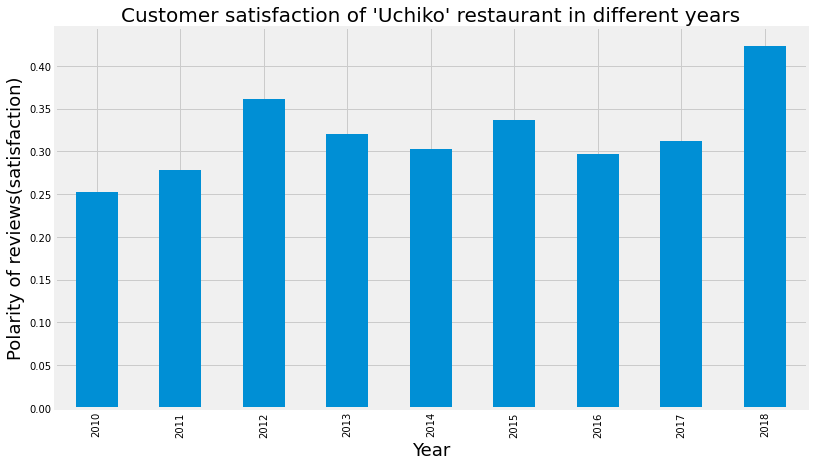

In [32]:
draw_polarity_review('Uchiko')

## 레소트랑 평점 출력

In [33]:
def draw_ratings(name):
  restaurant_only = restaurants.loc[restaurants['name'] == name ]
  # filter reviews for only Earl of Sandwich
  restaurant_review = review.loc[review['business_id'].isin(restaurant_only.business_id)]

  # clear the text
  restaurant_review['text_clear'] = restaurant_review['text'].apply(preprocess)

  # convert date column to pandas datatime 
  restaurant_review.date = pd.to_datetime(restaurant_review.date)
  # now we take the date column as base and count mean of stars of each unique date year (I am using pandas groupby function for this. If you don't know what pandas groupby function does, please search on Google)
  # then plot the graph
  restaurant_review.groupby(restaurant_review.date.dt.year)['stars'].mean().plot(kind='bar', figsize=(12, 7))
  # set the title of graph
  plt.title(f"'{name}' restaurant ratings in different years", fontsize=20)
  # set xlabel
  plt.xlabel('Year', fontsize=18)
  # set ylabel
  plt.ylabel('Stars', fontsize=18)
  # finally show the plot
  plt.show()

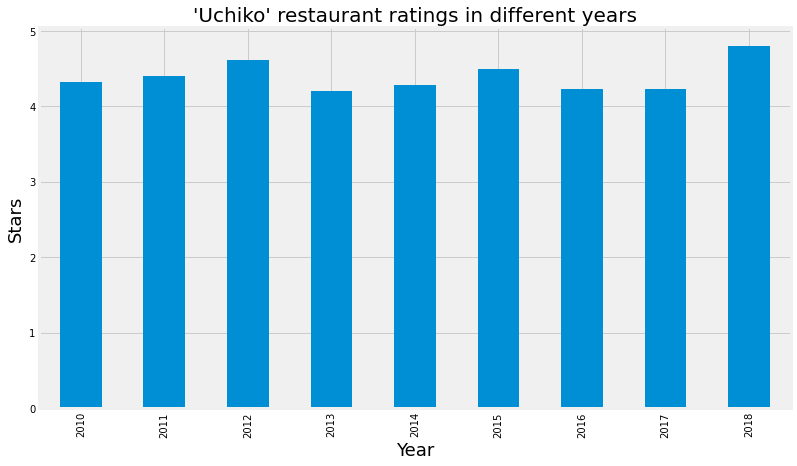

In [34]:
draw_ratings('Uchiko')

# 감사합니다. 내년에 봐요